# About

This notebook replicates the demonstration of the evomap package in the paper:

Matthe, Maximilian (2023), "evomap: A Python Package for Dynamic Mapping". 

Python environment: evomap-package

For details on the used package versions, see the file evomap-package-environment.yml

All code was run on MacOS 13.4.1.

# Setup

First, create path variabels for each subfolder and import the essential packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import os

PATH_HOME = os.path.dirname(os.getcwd()) # parent folder
PATH_OUT = os.path.join(PATH_HOME, 'gen') # output folder
PATH_DATA = os.path.join(PATH_HOME, 'data') # input folder

# Plotting parameters
title_fontdict = {'size': 18, 'family': 'Arial'}
title_fontdict_large = {'size': 20, 'family': 'Arial'}
label_fontdict = {'size': 16, 'family': 'Arial'}
label_fontdict_large = {'size': 18, 'family': 'Arial'}

# Set random seed for reproducibility
np.random.seed(111)

# Part 1: Quick Illustration of Static vs. Dynamic Mapping

This first part provides a quick illustration of how EvoMap can be applied using the evomap package. It also highlights the differences between applying EvoMap vs. applying existent static mapping methods.

The following code displays the necessary steps to generate the output shown in section 2 of the paper ('background on mapping'). 

## Loading the Data

For most of this illustration, we use a small sample from the TNIC data available through the dataset submodule.

In [2]:
from evomap.datasets import load_tnic_sample_tech

data = load_tnic_sample_tech()

The sample is organized as an edgelist where each observation corresponds to a single firm-firm pair. It contains a total of 9 firms and their pairiwse relationships over 20 years.

In [3]:
data.groupby('name1').agg({'year':'nunique'})

,year
name1,
APPLE INC,20
AT&T INC,20
EBAY INC,20
INTUIT INC,20
MICRON TECHNOLOGY INC,20
MICROSOFT CORP,20
ORACLE CORP,20
US CELLULAR CORP,20
WESTERN DIGITAL CORP,20


First, transform the edgelist into a sequence of similarity matrices

In [4]:
from evomap.preprocessing import edgelist2matrices
S_t, labels_t = edgelist2matrices(
    data, 
    score_var = 'score', 
    id_var_i = 'name1', 
    id_var_j = 'name2', 
    time_var = 'year')

The result is a sequence of matrices and a sequence of labels. As the sample is balanced, all labels remain the same over time in this example. Therefore, we simply use the first list of labels in what follows. 

In [5]:
labels = labels_t[0]
labels

array(['APPLE INC', 'AT&T INC', 'EBAY INC', 'INTUIT INC',
       'MICRON TECHNOLOGY INC', 'MICROSOFT CORP', 'ORACLE CORP',
       'US CELLULAR CORP', 'WESTERN DIGITAL CORP'], dtype=object)

Preview a single similarity matrix.

In [6]:
S_t[0].round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.06, 0.04, 0.  , 0.07],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.08, 0.  ],
       [0.  , 0.  , 0.  , 0.09, 0.  , 0.03, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.09, 0.  , 0.  , 0.05, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.03],
       [0.06, 0.  , 0.03, 0.05, 0.  , 0.  , 0.1 , 0.  , 0.03],
       [0.04, 0.  , 0.  , 0.  , 0.  , 0.1 , 0.  , 0.  , 0.03],
       [0.  , 0.08, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.07, 0.  , 0.  , 0.  , 0.03, 0.03, 0.03, 0.  , 0.  ]])

To map this similarity matrix via MDS, first transform it into dissimilarities using the sim2diss function from the preprocessing submodule.

In [7]:
from evomap.preprocessing import sim2diss
D_t = []
for S in S_t:
    D_t.append(sim2diss(S, transformation = 'mirror'))

In [8]:
D_t[0].shape

(9, 9)

In [9]:
D_t[0].round(2)

array([[0.  , 1.  , 1.  , 1.  , 1.  , 0.94, 0.96, 1.  , 0.93],
       [1.  , 0.  , 1.  , 1.  , 1.  , 1.  , 1.  , 0.92, 1.  ],
       [1.  , 1.  , 0.  , 0.91, 1.  , 0.97, 1.  , 1.  , 1.  ],
       [1.  , 1.  , 0.91, 0.  , 1.  , 0.95, 1.  , 1.  , 1.  ],
       [1.  , 1.  , 1.  , 1.  , 0.  , 1.  , 1.  , 1.  , 0.97],
       [0.94, 1.  , 0.97, 0.95, 1.  , 0.  , 0.9 , 1.  , 0.97],
       [0.96, 1.  , 1.  , 1.  , 1.  , 0.9 , 0.  , 1.  , 0.97],
       [1.  , 0.92, 1.  , 1.  , 1.  , 1.  , 1.  , 0.  , 1.  ],
       [0.93, 1.  , 1.  , 1.  , 0.97, 0.97, 0.97, 1.  , 0.  ]])

## Illustration of Static Mapping

First, we create static snapshots of these matrices using MDS. 

In [10]:
periods = data.year.unique()
n_periods = len(periods)
n_samples = len(labels)

In [11]:
print("First snapshot corresponds to the year {0}".format(periods[0]))

First snapshot corresponds to the year 1998


In [12]:
D_0 = D_t[0]

Here, we use non-metric ordinal MDS, initialized via Classical Scaling. 

In [13]:
from evomap.mapping import MDS
mds = MDS(mds_type = 'ordinal', init = 'cmds', verbose = True)
X_0 = mds.fit_transform(D_0)

[MDS] Running Gradient Descent with Backtracking via Halving
[MDS] Iteration 24: gradient norm vanished. Final cost: 0.14


To display the results, first draw a single snapshot.

In [14]:
from matplotlib import pyplot as plt
from evomap.printer import draw_map

fig, ax = plt.subplots(1,2, figsize = (16,8))
draw_map(
    X_0, 
    label = labels, 
    show_axes = True, 
    axes_at_origin = False, 
    show_grid = False, 
    ax = ax[0])

ax[0].set_title('A: Static MDS Map \n', fontdict= title_fontdict_large)


Text(0.5, 1.0, 'A: Static MDS Map \n')

Next, add the Shepard diagram to evaluate the snapshot's mapping quality. 

In [15]:
from evomap.printer import draw_shepard_diagram
    
draw_shepard_diagram(X_0, D_0, ax = ax[1])
ax[1].set_title('B: Shepard Diagram \n', fontdict= title_fontdict_large)
ax[1].legend(['Observed dissimilarities', 'Transformed dissimilariites'], loc = 4, prop = label_fontdict)

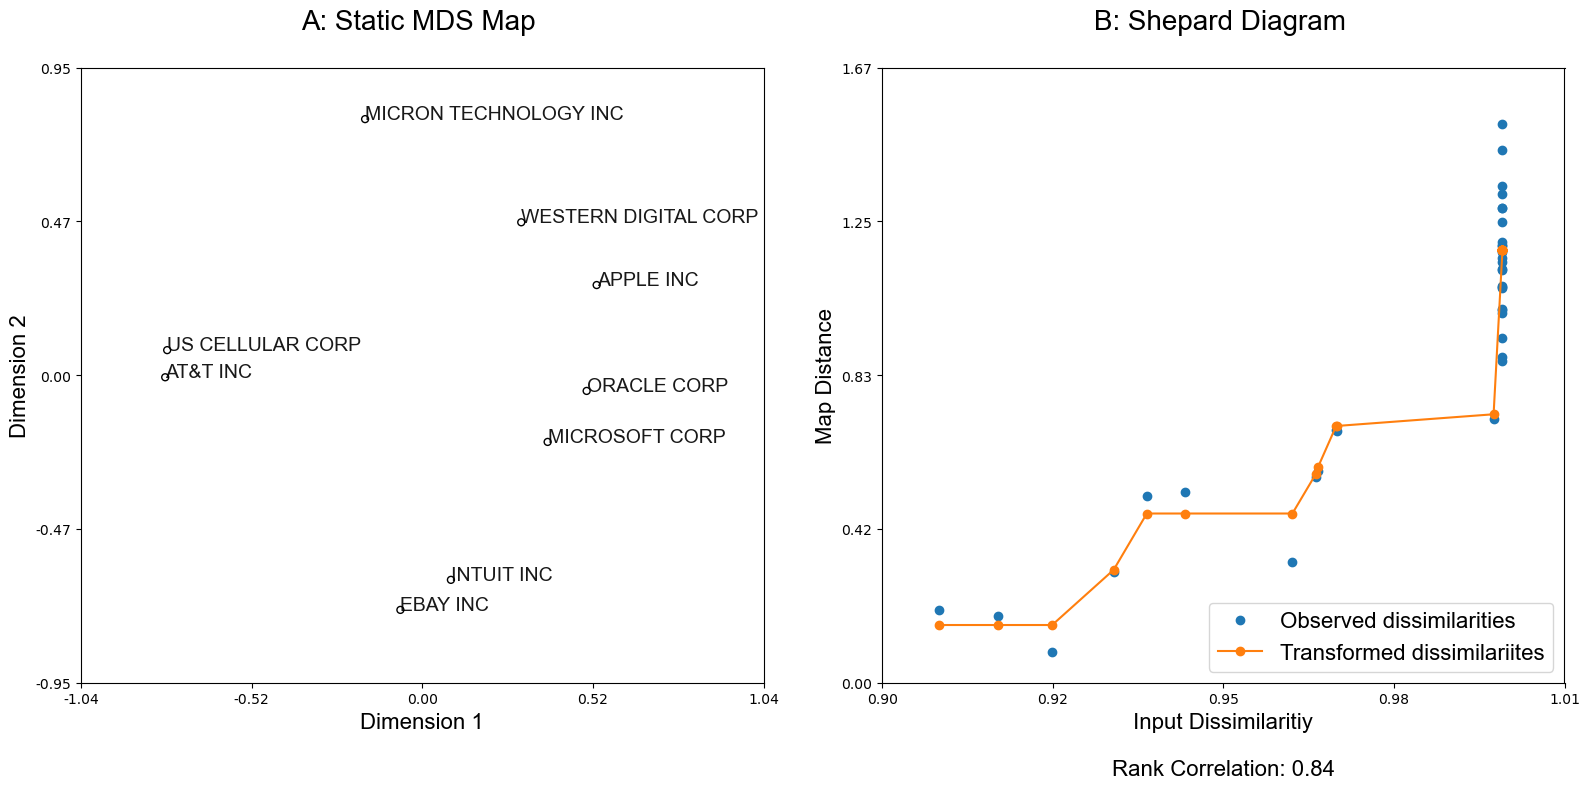

In [16]:
fig.tight_layout()
fig

In [17]:
print("Final Stress value: {0:.2f}".format(mds.cost_))

Final Stress value: 0.14


Save the Figure as Figure 1 of the Paper.

In [18]:
fig.savefig(os.path.join(PATH_OUT, 'Fig1_static_mapping.PNG'), dpi = 1200)
fig.savefig(os.path.join(PATH_OUT, 'Fig1_static_mapping.svg'), dpi = 1200)

## Dynamic Mapping via EvoMap

To illustrate Dynamic Mapping, we apply EvoMap, implemented for MDS, to the entire sequence of matrices. 

First, generate a sequence of starting configurations using the Classical Scaling solution as before.

Further, we try to align the independently created configurations as best using static MDS by using a constant starting initialization and applying Procrustes Analysis to the resultant sequence. 

To do so, |first create a sequence of starting configurations.

In [19]:
from evomap.mapping import CMDS
cmds_t = []
cmds = CMDS().fit_transform(D_t[0])
for t in range(n_periods):
    cmds_t.append(cmds)

In [20]:
print(cmds)

[[ 0.24075373  0.20881171]
 [-0.42117784  0.14527499]
 [-0.04673686 -0.44899406]
 [-0.00644986 -0.45689386]
 [-0.06853872  0.10641061]
 [ 0.2862593  -0.06071835]
 [ 0.2684813   0.12024825]
 [-0.42117784  0.14527499]
 [ 0.1685868   0.24058571]]


Then, apply EvoMap. Here, we set the alignment penalty (alpha) to .2, and add some smoothing by increasing p to 2:

In [21]:
from evomap.mapping import EvoMDS

evomds = EvoMDS(
    alpha = .2, 
    p = 2, 
    mds_type = 'ordinal', 
    init = cmds_t)

X_t = evomds.fit_transform(D_t) 

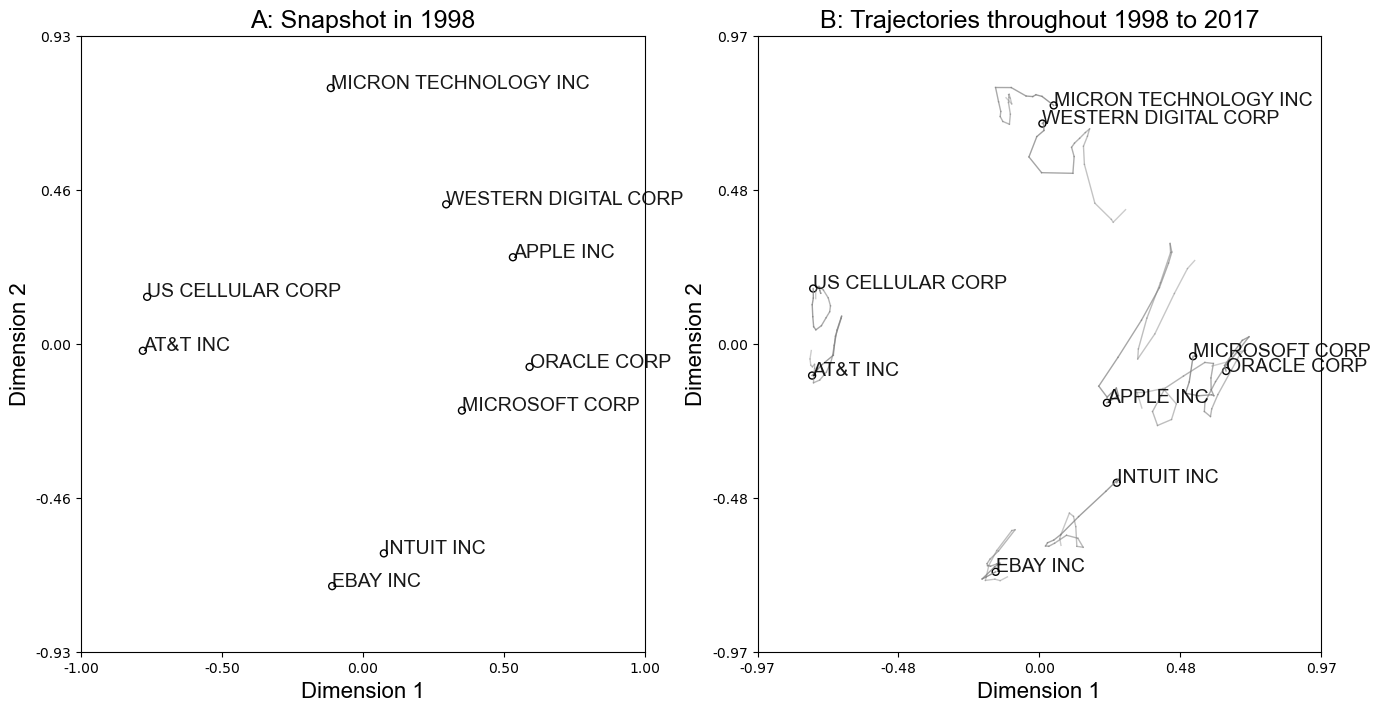

In [22]:
from evomap.printer import draw_dynamic_map

fig, ax = plt.subplots(1,2, figsize = (16, 8))

draw_map(X_t[0], label = labels, show_axes = True, ax = ax[0])
draw_dynamic_map(X_t, 
                 show_last_positions_only = True, 
                 show_arrows = True, 
                 label = labels, 
                 show_axes = True,
                 transparency_start=.4,
                 transparency_end=.8, 
                 ax = ax[1])

ax[0].set_title('A: Snapshot in {}'.format(periods[0]), fontdict = title_fontdict)
ax[1].set_title('B: Trajectories throughout {0} to {1}'.format(periods[0], periods[-1]), fontdict = title_fontdict)

fig

In [23]:
print("The maps represent the evolving positions over {0} years between {1} and {2}".format(n_periods, periods[0], periods[-1]))

The maps represent the evolving positions over 20 years between 1998 and 2017


Save the Figure as Figure 2 in the paper.

In [24]:
fig.savefig(os.path.join(PATH_OUT, 'Fig2_dynamic_mapping.PNG'), dpi = 1200)
fig.savefig(os.path.join(PATH_OUT, 'Fig2_dynamic_mapping.svg'), dpi = 1200)

# Part 2: Detailed Usage Example

This part goes through each step performed above in more details. The following sections provide more details about each step, showcases available options, and illustrates their respective impact.  

## Basic Syntax

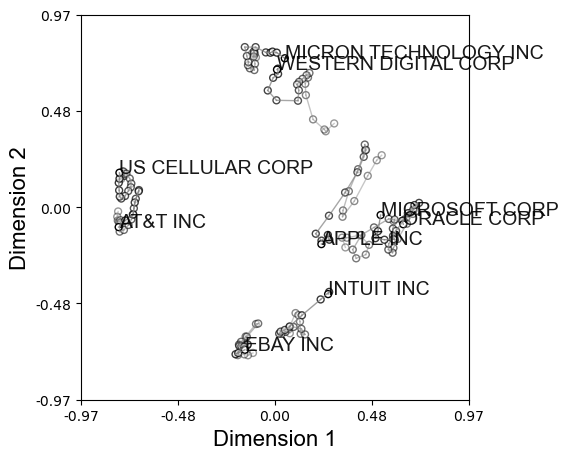

In [25]:
evomds = EvoMDS(
    alpha = .2, 
    p = 2, 
    mds_type = 'ordinal', 
    init = cmds_t)

X_t = evomds.fit_transform(D_t) 

draw_dynamic_map(X_t, label = labels, show_arrows= True, show_axes = True)

In [26]:
fig, ax = plt.subplots(figsize = (6,6))
draw_dynamic_map(X_t, label = labels, show_arrows= True, show_axes = True, ax = ax)
fig.savefig(os.path.join(PATH_OUT, 'Fig3_dynamic_map.PNG'), dpi = 1200)
fig.savefig(os.path.join(PATH_OUT, 'Fig3_dynamic_map.svg'), dpi = 1200)


## Preprocessing

In [27]:
table_overview = pd.concat([data.head(), data.tail()], axis = 0)
table_overview = table_overview[['year', 'name1', 'name2', 'score', 'sic1', 'sic2', 'size1', 'size2']]
table_overview.size1 = table_overview.size1.round(2)
table_overview.size2 = table_overview.size2.round(2)
table_overview

,year,name1,name2,score,sic1,sic2,size1,size2
0,1998,APPLE INC,WESTERN DIGITAL CORP,0.0657,36,35,71.79,32.29
1,1998,APPLE INC,MICROSOFT CORP,0.0601,36,73,71.79,517.38
2,1998,APPLE INC,ORACLE CORP,0.0355,36,73,71.79,188.44
3,1998,AT&T INC,US CELLULAR CORP,0.0761,48,48,324.14,57.62
4,1998,EBAY INC,MICROSOFT CORP,0.0281,73,73,98.54,517.38
437,2017,ORACLE CORP,MICROSOFT CORP,0.1292,73,73,432.13,728.91
438,2017,ORACLE CORP,INTUIT INC,0.0231,73,73,432.13,187.30
439,2017,US CELLULAR CORP,AT&T INC,0.0184,48,48,56.56,488.57
440,2017,WESTERN DIGITAL CORP,APPLE INC,0.0321,35,36,161.40,888.85
441,2017,WESTERN DIGITAL CORP,MICRON TECHNOLOGY INC,0.0788,35,36,161.40,188.55


In [28]:
table_overview.to_latex()

'\\begin{tabular}{lrllrrrrr}\n\\toprule\n & year & name1 & name2 & score & sic1 & sic2 & size1 & size2 \\\\\n\\midrule\n0 & 1998 & APPLE INC & WESTERN DIGITAL CORP & 0.065700 & 36 & 35 & 71.790000 & 32.290000 \\\\\n1 & 1998 & APPLE INC & MICROSOFT CORP & 0.060100 & 36 & 73 & 71.790000 & 517.380000 \\\\\n2 & 1998 & APPLE INC & ORACLE CORP & 0.035500 & 36 & 73 & 71.790000 & 188.440000 \\\\\n3 & 1998 & AT&T INC & US CELLULAR CORP & 0.076100 & 48 & 48 & 324.140000 & 57.620000 \\\\\n4 & 1998 & EBAY INC & MICROSOFT CORP & 0.028100 & 73 & 73 & 98.540000 & 517.380000 \\\\\n437 & 2017 & ORACLE CORP & MICROSOFT CORP & 0.129200 & 73 & 73 & 432.130000 & 728.910000 \\\\\n438 & 2017 & ORACLE CORP & INTUIT INC & 0.023100 & 73 & 73 & 432.130000 & 187.300000 \\\\\n439 & 2017 & US CELLULAR CORP & AT&T INC & 0.018400 & 48 & 48 & 56.560000 & 488.570000 \\\\\n440 & 2017 & WESTERN DIGITAL CORP & APPLE INC & 0.032100 & 35 & 36 & 161.400000 & 888.850000 \\\\\n441 & 2017 & WESTERN DIGITAL CORP & MICRON TECHNOL

In [29]:
table_overview.to_excel(os.path.join(PATH_OUT, "table2-data-overview.xlsx"))

The basic syntax to use evomap consists of the following lines of code, which instantinates the method and fits it to the data. Note that the import statement is not necessary here, as we imported the class before, but only included for completeness of this minimal example. 

In [30]:
from evomap.mapping import EvoMDS

evomds = EvoMDS(
    alpha = .2, 
    p = 2, 
    mds_type = 'ordinal', 
    init = cmds_t)

X_t = evomds.fit_transform(D_t) 

The output is a list of arrays shape (n_samples, n_dims)

In [31]:
print(type(X_t))

<class 'list'>


In [32]:
print(len(X_t))

20


In [33]:
print(X_t[0].round(2))

[[ 0.53  0.26]
 [-0.78 -0.02]
 [-0.11 -0.73]
 [ 0.07 -0.63]
 [-0.11  0.77]
 [ 0.35 -0.2 ]
 [ 0.59 -0.07]
 [-0.77  0.14]
 [ 0.3   0.42]]


## Starting Positions

-- Run with a different set of starting positions (e.g. random) and comapre output. Nothing for the paper, only for here. 

## Hyperparameters

Varying levels of alpha:

In [34]:
X_t_low_alpha = EvoMDS(alpha = 0.01, mds_type = 'ordinal', init = cmds_t).fit_transform(D_t)
X_t_mid_alpha = EvoMDS(alpha = 0.2, mds_type = 'ordinal', init = cmds_t).fit_transform(D_t)
X_t_high_alpha = EvoMDS(alpha = 1.5, mds_type = 'ordinal', init = cmds_t).fit_transform(D_t)

Varying levels of p:

In [35]:
X_t_p1 = EvoMDS(alpha = .2, p = 1, mds_type = 'ordinal', init = cmds_t, verbose = 2).fit_transform(D_t)
X_t_p2 = EvoMDS(alpha = .2, p = 2, mds_type = 'ordinal', init = cmds_t, verbose = 2).fit_transform(D_t)
X_t_p3 = EvoMDS(alpha = .2, p = 3, mds_type = 'ordinal', init = cmds_t, verbose = 2).fit_transform(D_t)

[EvoMDS] Running Gradient Descent with Backtracking via Halving
[EvoMDS] Iteration 50 -- Cost: 3.80 -- Gradient Norm: 0.0058
[EvoMDS] Iteration 100 -- Cost: 3.80 -- Gradient Norm: 0.0036
[EvoMDS] Iteration 101: gradient norm vanished. Final cost: 3.80
[EvoMDS] Running Gradient Descent with Backtracking via Halving
[EvoMDS] Iteration 50 -- Cost: 3.88 -- Gradient Norm: 0.0149
[EvoMDS] Iteration 100 -- Cost: 3.88 -- Gradient Norm: 0.0046
[EvoMDS] Iteration 150 -- Cost: 3.87 -- Gradient Norm: 0.0058
[EvoMDS] Iteration 200 -- Cost: 3.87 -- Gradient Norm: 0.0063
[EvoMDS] Iteration 250 -- Cost: 3.87 -- Gradient Norm: 0.0091
[EvoMDS] Iteration 300 -- Cost: 3.87 -- Gradient Norm: 0.0055
[EvoMDS] Iteration 350 -- Cost: 3.87 -- Gradient Norm: 0.0038
[EvoMDS] Iteration 400 -- Cost: 3.87 -- Gradient Norm: 0.0112
[EvoMDS] Iteration 450 -- Cost: 3.86 -- Gradient Norm: 0.0053
[EvoMDS] Iteration 500 -- Cost: 3.86 -- Gradient Norm: 0.0030
[EvoMDS] Iteration 533: gradient norm vanished. Final cost: 3.86


Plot results:

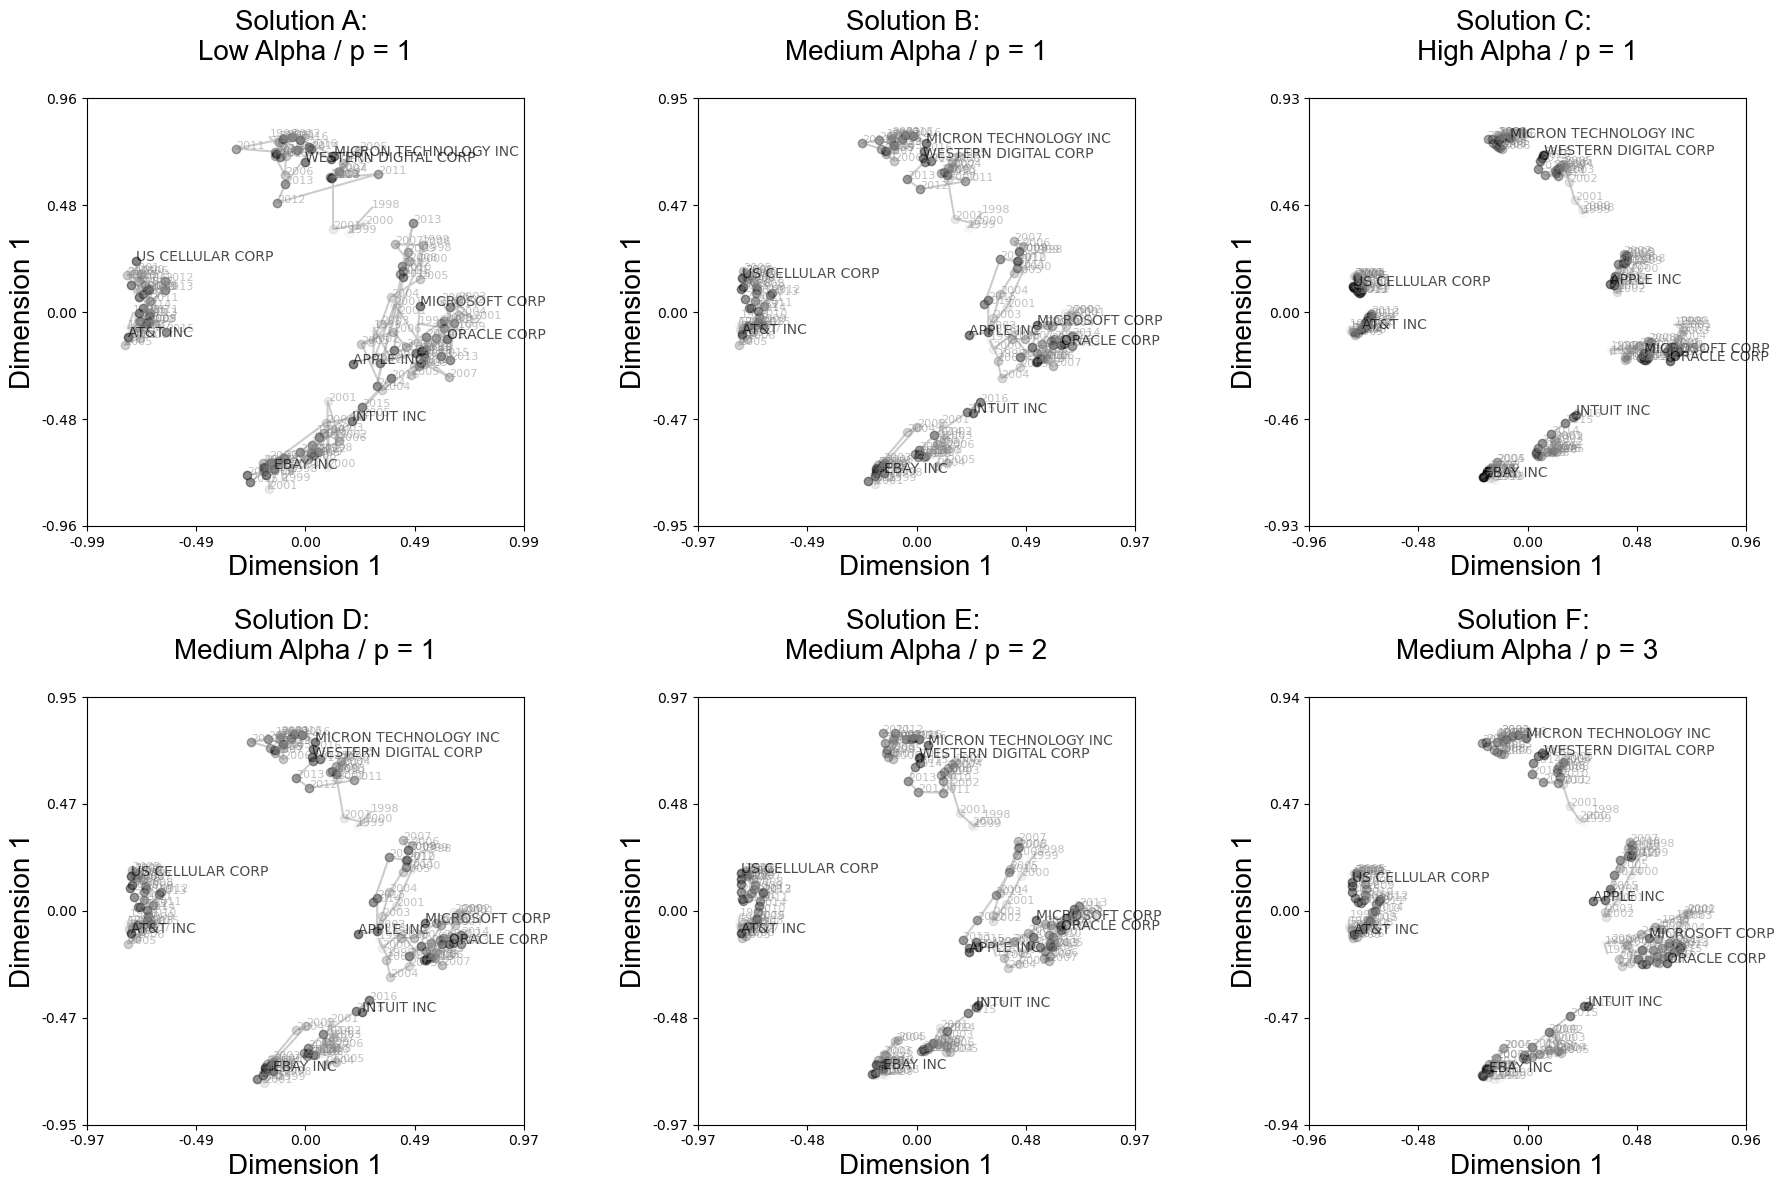

In [36]:
from evomap.printer import draw_trajectories
fig, ax = plt.subplots(2,3,figsize = (18,12))

draw_trajectories(X_t_low_alpha, show_axes= True, labels = labels, period_labels= periods, ax = ax[0,0])
draw_trajectories(X_t_mid_alpha, labels = labels, period_labels = periods, show_axes=True, ax = ax[0,1])
draw_trajectories(X_t_high_alpha, labels = labels, period_labels = periods, show_axes = True, ax = ax[0,2])

draw_trajectories(X_t_p1, show_axes= True, labels = labels, period_labels= periods, ax = ax[1,0])
draw_trajectories(X_t_p2, labels = labels, period_labels = periods, show_axes=True, ax = ax[1,1])
draw_trajectories(X_t_p3, labels = labels, period_labels = periods, show_axes = True, ax = ax[1,2])

ax[0,0].set_title('Solution A: \nLow Alpha / p = 1\n', fontdict = title_fontdict_large)
ax[0,1].set_title('Solution B: \nMedium Alpha / p = 1\n', fontdict = title_fontdict_large)
ax[0,2].set_title('Solution C: \nHigh Alpha / p = 1\n', fontdict = title_fontdict_large)
ax[1,0].set_title('Solution D: \nMedium Alpha / p = 1\n', fontdict = title_fontdict_large)
ax[1,1].set_title('Solution E: \nMedium Alpha / p = 2\n', fontdict = title_fontdict_large)
ax[1,2].set_title('Solution F: \nMedium Alpha / p = 3\n', fontdict = title_fontdict_large)

ax[0,0].set_xlabel('Dimension 1', fontdict = title_fontdict_large)
ax[0,1].set_xlabel('Dimension 1', fontdict = title_fontdict_large)
ax[0,2].set_xlabel('Dimension 1', fontdict = title_fontdict_large)
ax[1,0].set_xlabel('Dimension 1', fontdict = title_fontdict_large)
ax[1,1].set_xlabel('Dimension 1', fontdict = title_fontdict_large)
ax[1,2].set_xlabel('Dimension 1', fontdict = title_fontdict_large)

ax[0,0].set_ylabel('Dimension 1', fontdict = title_fontdict_large)
ax[0,1].set_ylabel('Dimension 1', fontdict = title_fontdict_large)
ax[0,2].set_ylabel('Dimension 1', fontdict = title_fontdict_large)
ax[1,0].set_ylabel('Dimension 1', fontdict = title_fontdict_large)
ax[1,1].set_ylabel('Dimension 1', fontdict = title_fontdict_large)
ax[1,2].set_ylabel('Dimension 1', fontdict = title_fontdict_large)
fig.tight_layout()
fig.subplots_adjust(
    hspace= .4,
    wspace = .4
)
fig.savefig(os.path.join(PATH_OUT, 'Fig5_hyperparamters.PNG'), dpi = 1200)
fig.savefig(os.path.join(PATH_OUT, 'Fig5_hyperparamters.svg'), dpi = 1200)

fig

## Convergence Diagnostics

In [37]:
EvoMDS(
    alpha = .2, 
    p = 2,
    mds_type = 'ordinal', 
    init = cmds_t,
    verbose = 1).fit(D_t)

[EvoMDS] Running Gradient Descent with Backtracking via Halving
[EvoMDS] Iteration 533: gradient norm vanished. Final cost: 3.86


In [38]:
EvoMDS(
    alpha = .2,
    p = 2,
    mds_type = 'ordinal', 
    init = cmds_t,
    n_iter_check = 50,
    verbose = 2).fit(D_t)

[EvoMDS] Running Gradient Descent with Backtracking via Halving
[EvoMDS] Iteration 50 -- Cost: 3.88 -- Gradient Norm: 0.0149
[EvoMDS] Iteration 100 -- Cost: 3.88 -- Gradient Norm: 0.0046
[EvoMDS] Iteration 150 -- Cost: 3.87 -- Gradient Norm: 0.0058
[EvoMDS] Iteration 200 -- Cost: 3.87 -- Gradient Norm: 0.0063
[EvoMDS] Iteration 250 -- Cost: 3.87 -- Gradient Norm: 0.0091
[EvoMDS] Iteration 300 -- Cost: 3.87 -- Gradient Norm: 0.0055
[EvoMDS] Iteration 350 -- Cost: 3.87 -- Gradient Norm: 0.0038
[EvoMDS] Iteration 400 -- Cost: 3.87 -- Gradient Norm: 0.0112
[EvoMDS] Iteration 450 -- Cost: 3.86 -- Gradient Norm: 0.0053
[EvoMDS] Iteration 500 -- Cost: 3.86 -- Gradient Norm: 0.0030
[EvoMDS] Iteration 533: gradient norm vanished. Final cost: 3.86


## Exploration

#### Static Exploration via Draw Map

Use static maps to compare snapshots

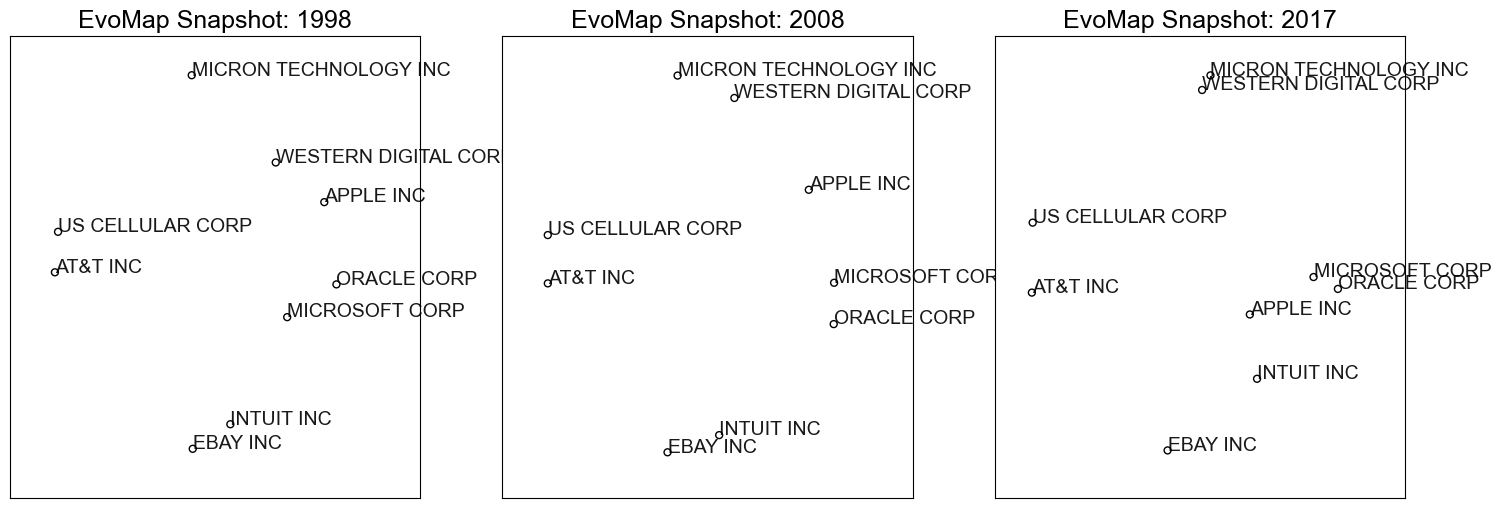

In [39]:
fig, ax = plt.subplots(1,3, figsize = (18,6))
draw_map(X_t[0], label = labels, ax = ax[0])
draw_map(X_t[10], label = labels, ax = ax[1])
draw_map(X_t[19], label = labels, ax = ax[2])

ax[0].set_title('EvoMap Snapshot: {0}'.format(periods[0]), **title_fontdict)
ax[1].set_title('EvoMap Snapshot: {0}'.format(periods[10]), **title_fontdict)
ax[2].set_title('EvoMap Snapshot: {0}'.format(periods[19]), **title_fontdict)

fig

In [40]:
fig.savefig(os.path.join(PATH_OUT, 'Fig6_static_snapshots.PNG'), dpi = 1200)
fig.savefig(os.path.join(PATH_OUT, 'Fig6_static_snapshots.svg'), dpi = 1200)

First, store some additional to augment the maps with.

SIC codes are categorical industry codes:

In [41]:
sic_codes = []
for firm in labels:
    sic_codes.append(data.query('name1 == @firm').sic1.unique()[0])
print(sic_codes)

[36, 48, 73, 73, 36, 73, 73, 48, 35]


Note that as data is sorted by years, the above code returns the SIC codes at the first availabel period. 

Size is a variable proportional to market value:

In [42]:
sizes = []
for firm in labels:
    sizes.append(data.query('name1 == @firm').size1.unique()[0].round(2))
print(sizes)

[71.79, 324.14, 98.54, 54.32, 69.69, 517.38, 188.44, 57.62, 32.29]


Such variables can be added to the map via the 'c' and 'size' arguments:

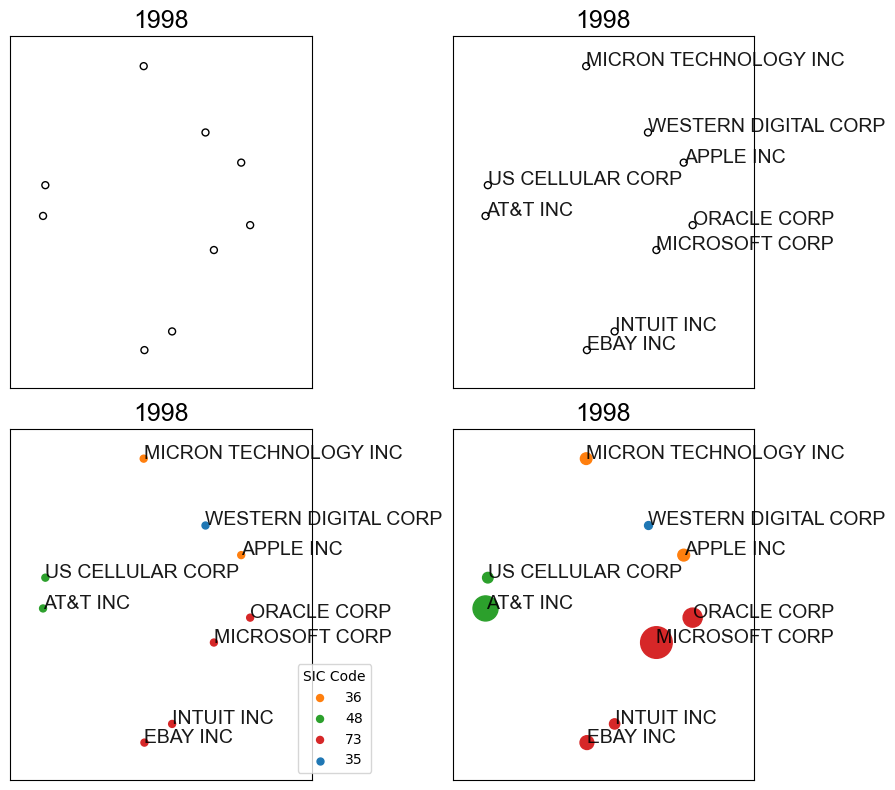

In [43]:
sic = data.sic1

fig, ax = plt.subplots(2,2,figsize = (9,8))
draw_map(X_t[0], title = periods[0], ax = ax[0,0])
draw_map(X_t[0], label = labels, title = periods[0], ax = ax[0,1])
draw_map(X_t[0], label = labels, color = sic_codes, show_legend = False, title = periods[0], ax = ax[1,0])
draw_map(X_t[0], label = labels, color = sic_codes, size = sizes, 
title = periods[0], ax = ax[1,1])
fig.tight_layout()

ax[1,0].legend(title = 'SIC Code', loc = 'lower right', bbox_to_anchor = (1.22, 0.0))
#lgnd = ax[1,1].legend(title = 'SIC Code', loc = 'lower left')
#for handle in lgnd.legend_handles:
#    handle.set_sizes([25.0])

fig.savefig(os.path.join(PATH_OUT, 'Fig7_draw_map_illustrations.PNG'), dpi = 1200)
fig.savefig(os.path.join(PATH_OUT, 'Fig7_draw_map_illustrations.svg'), dpi = 1200)

fig

### Draw Map Sequence

In [44]:
"""
from evomap.printer import draw_map_sequence
fig = draw_map_sequence(X_t[:4], 
                  color = sic_codes,
                  label = labels, 
                  size = sizes,
                  fig_size = (16,4),
                  n_cols = 4,
                  time_labels = periods[:4])

fig.tight_layout()
fig.savefig(os.path.join(PATH_OUT, 'sect4_draw_map_sequence.PNG'), dpi = 1200)
fig.savefig(os.path.join(PATH_OUT, 'sect4_draw_map_sequence.svg'), dpi = 1200)

fig
"""

"\nfrom evomap.printer import draw_map_sequence\nfig = draw_map_sequence(X_t[:4], \n                  color = sic_codes,\n                  label = labels, \n                  size = sizes,\n                  fig_size = (16,4),\n                  n_cols = 4,\n                  time_labels = periods[:4])\n\nfig.tight_layout()\nfig.savefig(os.path.join(PATH_OUT, 'sect4_draw_map_sequence.PNG'), dpi = 1200)\nfig.savefig(os.path.join(PATH_OUT, 'sect4_draw_map_sequence.svg'), dpi = 1200)\n\nfig\n"

## Drawing Dynamic Maps

### Dynamic Map

In [45]:
sic_codes_t = []
sizes_t = []
for t in range(n_periods):
    # get data in period t
    data_this = data.query('year == @periods[@t]')
    # get all sic codes in period t
    sic_this = []
    for firm in labels:
        sic_this.append(data_this.query('name1 == @firm').sic1.unique()[0])

    sic_codes_t.append(np.array(sic_this))    

    sizes_this = []
    for firm in labels:
        sizes_this.append(data_this.query('name1 == @firm').size1.unique()[0])
    
    sizes_t.append(np.array(sizes_this))


In [46]:
fig, ax = plt.subplots(1,2, figsize = (12,6))

from evomap.printer import draw_dynamic_map
draw_dynamic_map(X_t,
                 label = labels,
                 color_t = sic_codes_t,
                 size_t = sizes_t,
                 show_arrows = True,
                 show_axes = True,
                 title = 'A: Dynamic Map',
                 ax = ax[0])

### Draw Trajectories

In [47]:
from evomap.printer import draw_trajectories
draw_trajectories(X_t, 
                  labels = labels, 
                  period_labels = periods, 
                  show_axes=True,
                  title = "B: Trajectories", 
                  ax = ax[1])

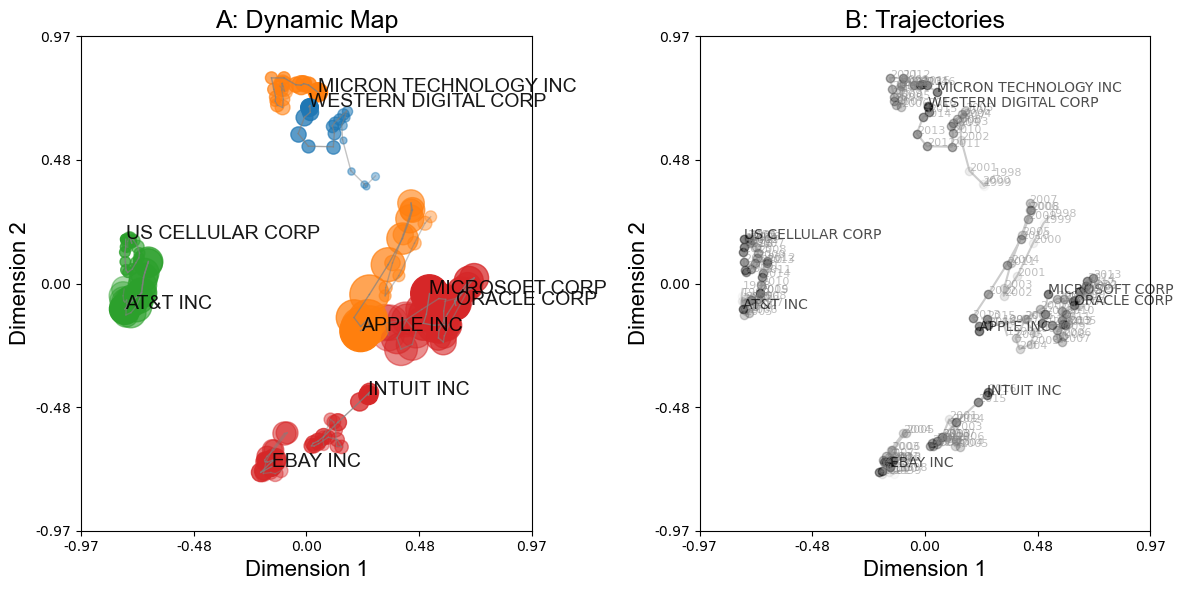

In [48]:
fig.tight_layout()
fig.savefig(os.path.join(PATH_OUT, 'Fig8_dynamic_map_and_trajectories.PNG'), dpi = 1200)
fig.savefig(os.path.join(PATH_OUT, 'Fig8_dynamic_map_and_trajectories.svg'), dpi = 1200)

fig

## Evaluation

### Cost Function Values

In [49]:
evomds_indep = EvoMDS(
    alpha = 0,  
    init = cmds_t, 
    mds_type= 'ordinal').fit(D_t)

print(evomds_indep.cost_static_avg_.round(4))
print(evomds.cost_static_avg_.round(4))

0.1802
0.191


### Evaluation Metrics

Compute metrics for EvoMap solution

In [50]:
from evomap.metrics import *
misalign_score(X_t).round(4)

0.0443

In [51]:
persistence_score(X_t).round(4)

0.6417

In [52]:
from evomap.transform import align_maps
X_t_indep = []
for D in D_t:
    X_t_indep.append(MDS(mds_type='ordinal', init = 'cmds').fit_transform(D))

X_t_indep_aligned = align_maps(X_t_indep, X_t[0])


In [53]:
from evomap.metrics import *

misalign_score_t = []
persistence_score_t = []
avg_hitrate_score_t = []

for i, X in enumerate([X_t, X_t_indep, X_t_indep_aligned]):
    misalign_score_t.append(misalign_score(X))
    persistence_score_t.append(persistence_score(X))
    avg_hitrate_score_t.append(avg_hitrate_score(X, D_t, input_format='dissimilarity', n_neighbors=4))
  
metrics = pd.DataFrame({'misalign_score': misalign_score_t, 
                        'persistence_score': persistence_score_t,
                        'hitrate_score': avg_hitrate_score_t},
                          index = ['EvoMDS', 'Independent MDS', 'Independent MDS + Alignment'])

metrics['average_stress'] = [evomds.cost_static_avg_, evomds_indep.cost_static_avg_, evomds_indep.cost_static_avg_]

# sort metrics such that the order is Independent MDS, Independent MDS + Alignment, EvoMDS
metrics = metrics.reindex(['Independent MDS', 'Independent MDS + Alignment', 'EvoMDS'])
metrics.round(4)

,misalign_score,persistence_score,hitrate_score,average_stress
Independent MDS,1.0395,-0.6234,0.6944,0.1802
Independent MDS + Alignment,0.3203,-0.2728,0.6944,0.1802
EvoMDS,0.0443,0.6417,0.7083,0.1910


In [54]:
print(metrics.round(4).to_latex())

\begin{tabular}{lrrrr}
\toprule
 & misalign_score & persistence_score & hitrate_score & average_stress \\
\midrule
Independent MDS & 1.039500 & -0.623400 & 0.694400 & 0.180200 \\
Independent MDS + Alignment & 0.320300 & -0.272800 & 0.694400 & 0.180200 \\
EvoMDS & 0.044300 & 0.641700 & 0.708300 & 0.191000 \\
\bottomrule
\end{tabular}



In [55]:
metrics.round(4).to_excel(os.path.join(PATH_OUT, 'sect4_metrics.xlsx'))

## Hyperparameter Tuning

### Use the Grid Search

First, define the parameter space across which the grid search shall be completed

In [56]:
param_grid = {
    'alpha': np.linspace(0, 1.5, 15), 
    'p': [1,2]}

Next, define the metrics on which each parameter combination is to be evaluated

In [57]:
from evomap.metrics import misalign_score, persistence_score, avg_hitrate_score

metrics = [misalign_score, persistence_score, avg_hitrate_score]
metric_labels = ['Misalignment', 'Persistence', 'Hitrate']

In [58]:
model = EvoMDS(init = cmds_t, mds_type = 'ordinal')

df_grid_results = model.grid_search(
    Xs = D_t, 
    param_grid = param_grid, 
    eval_functions =  metrics,
    eval_labels = metric_labels, 
    kwargs = {"input_format" : 'dissimilarity'})

Weights not calculated. Input data might be fully static.


/Users/mpmatthe/Dropbox (Personal)/Promotion/Research-Projects/Projects/02-Single-Author/Code/src/evomap/mapping/evomap/_core.py:50: RuntimeWarning: invalid value encountered in subtract
  delta = Xs[t] - Xs[t-1]
/Users/mpmatthe/Dropbox (Personal)/Promotion/Research-Projects/Projects/02-Single-Author/Code/src/evomap/mapping/evomap/_core.py:50: RuntimeWarning: invalid value encountered in subtract
  delta = Xs[t] - Xs[t-1]


Weights not calculated. Input data might be fully static.


/Users/mpmatthe/Dropbox (Personal)/Promotion/Research-Projects/Projects/02-Single-Author/Code/src/evomap/mapping/evomap/_core.py:50: RuntimeWarning: invalid value encountered in subtract
  delta = Xs[t] - Xs[t-1]


Weights not calculated. Input data might be fully static.


/Users/mpmatthe/Dropbox (Personal)/Promotion/Research-Projects/Projects/02-Single-Author/Code/src/evomap/mapping/evomap/_core.py:50: RuntimeWarning: invalid value encountered in subtract
  delta = Xs[t] - Xs[t-1]


Weights not calculated. Input data might be fully static.


/Users/mpmatthe/Dropbox (Personal)/Promotion/Research-Projects/Projects/02-Single-Author/Code/src/evomap/mapping/evomap/_core.py:50: RuntimeWarning: invalid value encountered in subtract
  delta = Xs[t] - Xs[t-1]


Weights not calculated. Input data might be fully static.


/Users/mpmatthe/Dropbox (Personal)/Promotion/Research-Projects/Projects/02-Single-Author/Code/src/evomap/mapping/evomap/_core.py:50: RuntimeWarning: invalid value encountered in subtract
  delta = Xs[t] - Xs[t-1]


Weights not calculated. Input data might be fully static.


/Users/mpmatthe/Dropbox (Personal)/Promotion/Research-Projects/Projects/02-Single-Author/Code/src/evomap/mapping/evomap/_core.py:50: RuntimeWarning: invalid value encountered in subtract
  delta = Xs[t] - Xs[t-1]


Weights not calculated. Input data might be fully static.


/Users/mpmatthe/Dropbox (Personal)/Promotion/Research-Projects/Projects/02-Single-Author/Code/src/evomap/mapping/evomap/_core.py:50: RuntimeWarning: invalid value encountered in subtract
  delta = Xs[t] - Xs[t-1]


Weights not calculated. Input data might be fully static.


/Users/mpmatthe/Dropbox (Personal)/Promotion/Research-Projects/Projects/02-Single-Author/Code/src/evomap/mapping/evomap/_core.py:50: RuntimeWarning: invalid value encountered in subtract
  delta = Xs[t] - Xs[t-1]


Weights not calculated. Input data might be fully static.


/Users/mpmatthe/Dropbox (Personal)/Promotion/Research-Projects/Projects/02-Single-Author/Code/src/evomap/mapping/evomap/_core.py:50: RuntimeWarning: invalid value encountered in subtract
  delta = Xs[t] - Xs[t-1]


Weights not calculated. Input data might be fully static.


/Users/mpmatthe/Dropbox (Personal)/Promotion/Research-Projects/Projects/02-Single-Author/Code/src/evomap/mapping/evomap/_core.py:50: RuntimeWarning: invalid value encountered in subtract
  delta = Xs[t] - Xs[t-1]


Weights not calculated. Input data might be fully static.


/Users/mpmatthe/Dropbox (Personal)/Promotion/Research-Projects/Projects/02-Single-Author/Code/src/evomap/mapping/evomap/_core.py:50: RuntimeWarning: invalid value encountered in subtract
  delta = Xs[t] - Xs[t-1]


Weights not calculated. Input data might be fully static.


/Users/mpmatthe/Dropbox (Personal)/Promotion/Research-Projects/Projects/02-Single-Author/Code/src/evomap/mapping/evomap/_core.py:50: RuntimeWarning: invalid value encountered in subtract
  delta = Xs[t] - Xs[t-1]


Weights not calculated. Input data might be fully static.


/Users/mpmatthe/Dropbox (Personal)/Promotion/Research-Projects/Projects/02-Single-Author/Code/src/evomap/mapping/evomap/_core.py:50: RuntimeWarning: invalid value encountered in subtract
  delta = Xs[t] - Xs[t-1]


Weights not calculated. Input data might be fully static.


/Users/mpmatthe/Dropbox (Personal)/Promotion/Research-Projects/Projects/02-Single-Author/Code/src/evomap/mapping/evomap/_core.py:50: RuntimeWarning: invalid value encountered in subtract
  delta = Xs[t] - Xs[t-1]


Weights not calculated. Input data might be fully static.


/Users/mpmatthe/Dropbox (Personal)/Promotion/Research-Projects/Projects/02-Single-Author/Code/src/evomap/mapping/evomap/_core.py:50: RuntimeWarning: invalid value encountered in subtract
  delta = Xs[t] - Xs[t-1]


Weights not calculated. Input data might be fully static.


/Users/mpmatthe/Dropbox (Personal)/Promotion/Research-Projects/Projects/02-Single-Author/Code/src/evomap/mapping/evomap/_core.py:50: RuntimeWarning: invalid value encountered in subtract
  delta = Xs[t] - Xs[t-1]


Weights not calculated. Input data might be fully static.


/Users/mpmatthe/Dropbox (Personal)/Promotion/Research-Projects/Projects/02-Single-Author/Code/src/evomap/mapping/evomap/_core.py:50: RuntimeWarning: invalid value encountered in subtract
  delta = Xs[t] - Xs[t-1]


Weights not calculated. Input data might be fully static.
[EvoMDS] Diverging gradient norm at iteration 173
[EvoMDS] Adjusting step sizes..


/Users/mpmatthe/Dropbox (Personal)/Promotion/Research-Projects/Projects/02-Single-Author/Code/src/evomap/mapping/evomap/_core.py:50: RuntimeWarning: invalid value encountered in subtract
  delta = Xs[t] - Xs[t-1]


Weights not calculated. Input data might be fully static.


/Users/mpmatthe/Dropbox (Personal)/Promotion/Research-Projects/Projects/02-Single-Author/Code/src/evomap/mapping/evomap/_core.py:50: RuntimeWarning: invalid value encountered in subtract
  delta = Xs[t] - Xs[t-1]


Weights not calculated. Input data might be fully static.
[EvoMDS] Diverging gradient norm at iteration 79
[EvoMDS] Adjusting step sizes..


/Users/mpmatthe/Dropbox (Personal)/Promotion/Research-Projects/Projects/02-Single-Author/Code/src/evomap/mapping/evomap/_core.py:50: RuntimeWarning: invalid value encountered in subtract
  delta = Xs[t] - Xs[t-1]


Weights not calculated. Input data might be fully static.


/Users/mpmatthe/Dropbox (Personal)/Promotion/Research-Projects/Projects/02-Single-Author/Code/src/evomap/mapping/evomap/_core.py:50: RuntimeWarning: invalid value encountered in subtract
  delta = Xs[t] - Xs[t-1]


Weights not calculated. Input data might be fully static.
[EvoMDS] Diverging gradient norm at iteration 54
[EvoMDS] Adjusting step sizes..


/Users/mpmatthe/Dropbox (Personal)/Promotion/Research-Projects/Projects/02-Single-Author/Code/src/evomap/mapping/evomap/_core.py:50: RuntimeWarning: invalid value encountered in subtract
  delta = Xs[t] - Xs[t-1]


Weights not calculated. Input data might be fully static.


/Users/mpmatthe/Dropbox (Personal)/Promotion/Research-Projects/Projects/02-Single-Author/Code/src/evomap/mapping/evomap/_core.py:50: RuntimeWarning: invalid value encountered in subtract
  delta = Xs[t] - Xs[t-1]


Weights not calculated. Input data might be fully static.
[EvoMDS] Diverging gradient norm at iteration 43
[EvoMDS] Adjusting step sizes..


/Users/mpmatthe/Dropbox (Personal)/Promotion/Research-Projects/Projects/02-Single-Author/Code/src/evomap/mapping/evomap/_core.py:50: RuntimeWarning: invalid value encountered in subtract
  delta = Xs[t] - Xs[t-1]


Weights not calculated. Input data might be fully static.


/Users/mpmatthe/Dropbox (Personal)/Promotion/Research-Projects/Projects/02-Single-Author/Code/src/evomap/mapping/evomap/_core.py:50: RuntimeWarning: invalid value encountered in subtract
  delta = Xs[t] - Xs[t-1]


Weights not calculated. Input data might be fully static.
[EvoMDS] Diverging gradient norm at iteration 37
[EvoMDS] Adjusting step sizes..


/Users/mpmatthe/Dropbox (Personal)/Promotion/Research-Projects/Projects/02-Single-Author/Code/src/evomap/mapping/evomap/_core.py:50: RuntimeWarning: invalid value encountered in subtract
  delta = Xs[t] - Xs[t-1]


Weights not calculated. Input data might be fully static.


/Users/mpmatthe/Dropbox (Personal)/Promotion/Research-Projects/Projects/02-Single-Author/Code/src/evomap/mapping/evomap/_core.py:50: RuntimeWarning: invalid value encountered in subtract
  delta = Xs[t] - Xs[t-1]


Weights not calculated. Input data might be fully static.
[EvoMDS] Diverging gradient norm at iteration 32
[EvoMDS] Adjusting step sizes..


/Users/mpmatthe/Dropbox (Personal)/Promotion/Research-Projects/Projects/02-Single-Author/Code/src/evomap/mapping/evomap/_core.py:50: RuntimeWarning: invalid value encountered in subtract
  delta = Xs[t] - Xs[t-1]


Weights not calculated. Input data might be fully static.


/Users/mpmatthe/Dropbox (Personal)/Promotion/Research-Projects/Projects/02-Single-Author/Code/src/evomap/mapping/evomap/_core.py:50: RuntimeWarning: invalid value encountered in subtract
  delta = Xs[t] - Xs[t-1]


Weights not calculated. Input data might be fully static.
[EvoMDS] Diverging gradient norm at iteration 29
[EvoMDS] Adjusting step sizes..


In [59]:
df_grid_results.head()

,p,cost_static_avg,Misalignment,Persistence,Hitrate
alpha,,,,,
0.000000,1,0.180193,0.147856,-0.462382,0.9
0.000000,2,0.180193,0.147856,-0.462382,0.9
0.107143,1,0.186830,0.060721,0.251075,0.9
0.107143,2,0.192101,0.041383,0.641759,0.9
0.214286,1,0.191463,0.041588,0.383028,0.9


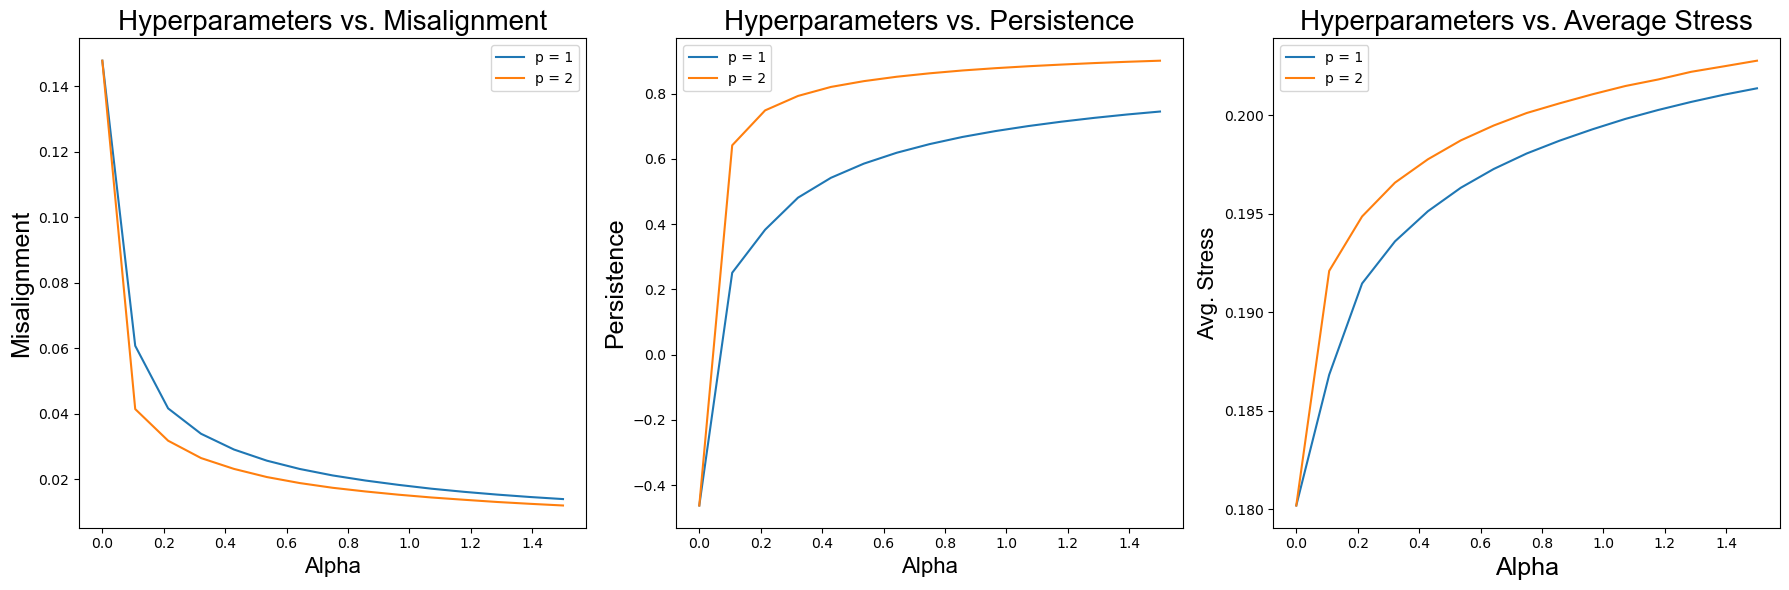

In [60]:
fig, ax = plt.subplots(1,3, figsize = (18, 6))
df_grid_results.groupby('p')['Misalignment'].plot(legend = True, ax = ax[0])
df_grid_results.groupby('p')['Persistence'].plot(legend = True, ax = ax[1])
df_grid_results.groupby('p')['cost_static_avg'].plot(legend = True, ax = ax[2])

ax[0].set_title('Hyperparameters vs. Misalignment', fontdict = title_fontdict_large)
ax[0].set_xlabel('Alpha', fontdict = label_fontdict)
ax[0].set_ylabel('Misalignment', fontdict = label_fontdict_large)
ax[0].legend(labels = ['p = 1', 'p = 2'])
ax[1].set_title('Hyperparameters vs. Persistence', fontdict = title_fontdict_large)
ax[1].set_xlabel('Alpha', fontdict = label_fontdict)
ax[1].set_ylabel('Persistence', fontdict = label_fontdict_large)
ax[1].legend(labels = ['p = 1', 'p = 2'])
ax[2].set_title('Hyperparameters vs. Average Stress', fontdict = title_fontdict_large)
ax[2].set_xlabel('Alpha', fontdict = label_fontdict_large)
ax[2].set_ylabel('Avg. Stress', fontdict = label_fontdict)
ax[2].legend(labels = ['p = 1', 'p = 2'])

fig.tight_layout()
fig.savefig(os.path.join(PATH_OUT, 'Fig9_grid_search.PNG'), dpi = 1200)
fig.savefig(os.path.join(PATH_OUT, 'Fig9_grid_search.svg'), dpi = 1200)

### Results across MDS Types

/Users/mpmatthe/Dropbox (Personal)/Promotion/Research-Projects/Projects/02-Single-Author/Code/src/evomap/mapping/evomap/_core.py:50: RuntimeWarning: invalid value encountered in subtract
  delta = Xs[t] - Xs[t-1]


Weights not calculated. Input data might be fully static.


/Users/mpmatthe/Dropbox (Personal)/Promotion/Research-Projects/Projects/02-Single-Author/Code/src/evomap/mapping/evomap/_core.py:50: RuntimeWarning: invalid value encountered in subtract
  delta = Xs[t] - Xs[t-1]


Weights not calculated. Input data might be fully static.


/Users/mpmatthe/Dropbox (Personal)/Promotion/Research-Projects/Projects/02-Single-Author/Code/src/evomap/mapping/evomap/_core.py:50: RuntimeWarning: invalid value encountered in subtract
  delta = Xs[t] - Xs[t-1]


Weights not calculated. Input data might be fully static.


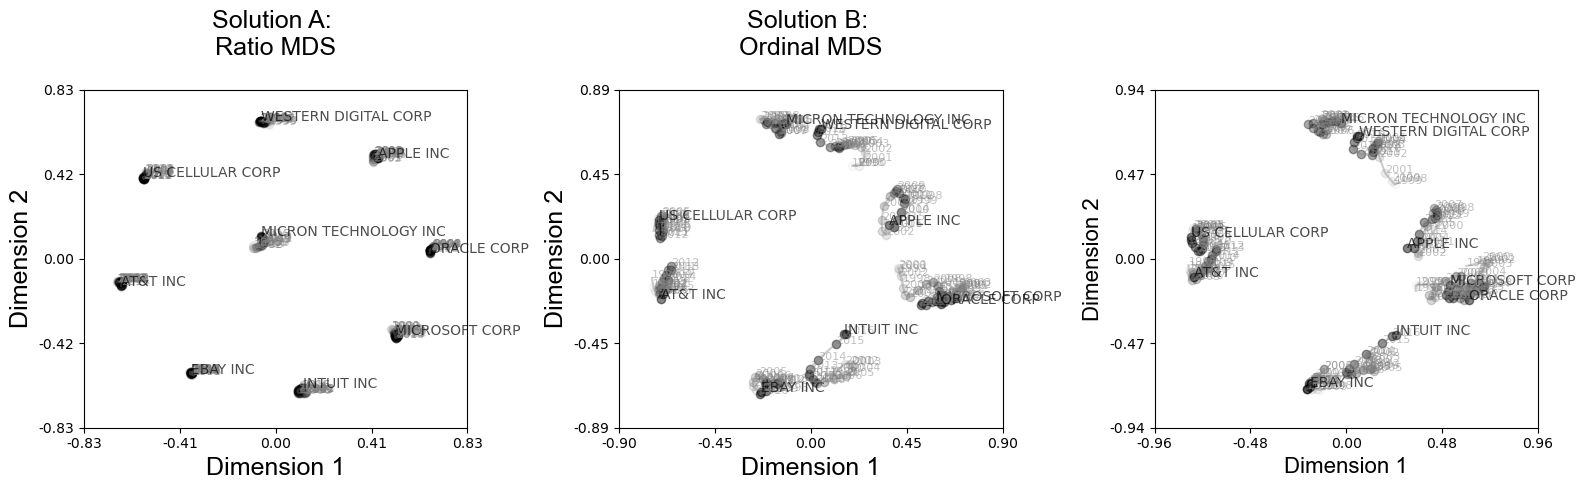

In [61]:
X_t_ratio = EvoMDS(alpha = .2, p = 2, mds_type = 'ratio', init = cmds_t).fit_transform(D_t)
X_t_interval = EvoMDS(alpha = .2, p = 2, mds_type = 'interval', init = cmds_t).fit_transform(D_t)
X_t_ordinal = EvoMDS(alpha = .2, p = 2, mds_type = 'ordinal', init = cmds_t).fit_transform(D_t)

fig, ax = plt.subplots(1,3,figsize = (16,5))
draw_trajectories(X_t_ratio, labels = labels, period_labels = periods, show_axes=True, ax = ax[0])
draw_trajectories(X_t_interval, labels = labels, period_labels = periods, show_axes=True, ax = ax[1])
draw_trajectories(X_t_ordinal, labels = labels, period_labels = periods, show_axes = True, ax = ax[2])
ax[0].set_title('Solution A: \nRatio MDS\n', fontdict = title_fontdict)
ax[1].set_title('Solution B: \nInterval MDS\n', fontdict = title_fontdict)
ax[1].set_title('Solution B: \nOrdinal MDS\n', fontdict = title_fontdict)

ax[0].set_xlabel("Dimension 1", fontdict = title_fontdict)
ax[1].set_xlabel("Dimension 1", fontdict = title_fontdict)
ax[0].set_ylabel("Dimension 2", fontdict = title_fontdict)
ax[1].set_ylabel("Dimension 2", fontdict = title_fontdict)

fig.tight_layout()
fig.savefig(os.path.join(PATH_OUT, 'sect5_mds_types.PNG'), dpi = 1200)
fig.savefig(os.path.join(PATH_OUT, 'sect5_mds_types.svg'), dpi = 1200)
fig

## Unbalanced Data

In [62]:
data_unbalanced = load_tnic_sample_tech(unbalanced = True)
data_unbalanced.groupby('name1').agg({'year': 'nunique'})

,year
name1,
APPLE INC,20
AT&T INC,20
EBAY INC,20
INTUIT INC,20
MICRON TECHNOLOGY INC,20
MICROSOFT CORP,20
NETFLIX INC,16
ORACLE CORP,20
US CELLULAR CORP,20


In [63]:
from evomap.preprocessing import edgelist2matrices
S_t, labels = edgelist2matrices(
    data_unbalanced, 
    score_var='score', 
    id_var_i='name1', 
    id_var_j='name2', 
    time_var = 'year')

In [64]:
print(S_t[0].shape)
print(S_t[-1].shape)

(9, 9)
(10, 10)


In [65]:
from evomap.preprocessing import expand_matrices
S_t, inc_t, labels = expand_matrices(S_t, labels)

In [66]:
print(S_t[0].shape)

(10, 10)


In [67]:
print(inc_t[0])

[True, True, True, True, True, True, False, True, True, True]


In [68]:
inc_t[-1]

[True, True, True, True, True, True, True, True, True, True]

In [69]:
D_t = []
for S in S_t:
    D = sim2diss(S, transformation='mirror')
    D_t.append(D)

In [70]:
inits_ts = [np.concatenate([cmds, np.array([[0,0]])], axis = 0) for cmds in cmds_t]

In [71]:
from evomap.mapping import EvoMDS
X_t = EvoMDS(alpha = 0.75, 
             p = 2,  
             mds_type = 'ordinal', 
             init = inits_ts,
             verbose=2).fit_transform(D_t, inclusions = inc_t)

[EvoMDS] Running Gradient Descent with Backtracking via Halving


ValueError: XA must be a 2-dimensional array.

In [ ]:
from matplotlib import pyplot as plt   
from evomap.printer import draw_map 
fig, ax = plt.subplots(1,2,figsize=(12, 6))
draw_map(X_t[0], 
         inclusions = inc_t[0], 
         label = labels, 
         ax = ax[0], 
         show_axes=True, 
         title = 'A: Snapshot in {0}'.format(periods[0]))
draw_map(X_t[-1], 
         inclusions = inc_t[-1], 
         label = labels, 
         ax = ax[1], 
         show_axes = True,
         title = 'B: Snapshot in {0}'.format(periods[-1])) 
fig.tight_layout()
fig.savefig(os.path.join(PATH_OUT, 'Fig10_unbalanced.PNG'), dpi = 1200)
fig.savefig(os.path.join(PATH_OUT, 'Fig10_unbalanced.svg'), dpi = 1200)
fig

# THE END

For further examples, using a larger dataset, see https://evomap.readthedocs.io/en/latest/dynamic%20mapping.html